In [66]:
import numpy as np
from aes import add_round_key, Sbox
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
plain = np.load('plaintexts.npy')
traces = np.load("traces.npy")
cipher = np.load("ciphertexts.npy")

In [12]:
cipher.shape

(1000, 16)

In [13]:
plain.shape

(1000, 16)

In [14]:
def hamming_weight(number):
    res = 0
    for bit in bin(number)[2:]:
        res += int(bit)
    return res

In [16]:
keys = [i for i in range(256)]

In [56]:
def attackOnByte(byte_chosen, display_graph = False): 
    add_round_key_output = np.array([[add_round_key(plain[j][byte_chosen],key)for key in keys] for j in range(len(plain))])
    
    # Sub_bytes prend en entrée la matrice 4x4 qui correspond 
    sub_byte_output = np.array([[Sbox[elm] for elm in res] for res in add_round_key_output])
    
    WHamming = np.array([[hamming_weight(elm) for elm in res] for res in sub_byte_output])
    
    correlation_list = []
    for possible_value in range(256):
        correlation_list.append([np.corrcoef(traces[:,number_try], WHamming[:,possible_value])[0,1] for number_try in range(traces.shape[1])] )

    if display_graph:
        for correlation in correlation_list[:]:
            plt.plot(correlation)
        plt.ylabel('Corrélation')
        plt.xlabel("Trace de mesure (octet : "+ str(byte_chosen)+ ")")
        plt.savefig("Graphique de corrélation")
        plt.show()
    
    # Détection basique de seuil, pourrait être améliorée
    threshold = 0.2
    result = set()
    for index, correlation in enumerate(correlation_list):
        for x in correlation : 
            if abs(x) > threshold : 
                #print ("La valeur {} semble être candidate pour l'octet {}".format(index, byte_chosen))
                result.add(index)
    if len(result) > 1: 
        print ("Threshold is not precise enough to attack octet {}".format(byte_chosen))
        return -1
    else : 
        return hex(result.pop())
    
    

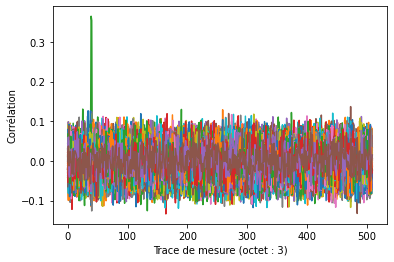

'0x16'

In [57]:
attackOnByte(3, True)

In [76]:
key = "0x"
for byte in tqdm(range(16)):
    key += attackOnByte(byte)[2:].zfill(2)
print ("Suite à l'attaque menée, la clé semble être : {}".format(key))

100%|██████████| 16/16 [03:07<00:00, 11.72s/it]

Suite à l'attaque menée, la clé semble être : 0x2b7e151628aed2a6abf7158809cf4f3c


In [82]:
original_key = "0x2b7e151628aed2a6abf7158809cf4f3c"
print (original_key == key)

True
